## Сборный проект 2

### Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. 

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Есть две задачи:

- Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

### Описание данных

Вот какие данные у нас есть от заказчика:

- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

### План работы

#### Шаг 1. Загрузка данных
Загрузим файлы с данными `train_job_satisfaction_rate.csv`, `test_features.csv`, `test_target_job_satisfaction_rate.csv`

#### Шаг 2. Предобработка данных
Изучим данные, при необходимости выполним предобработку. Если есть пропуски, заполним их в пайплайне.

#### Шаг 3. Исследовательский анализ данных
Исследуем все признаки и сделаем выводы о том, как их нужно подготовить.

#### Шаг 4. Подготовка данных
Подготовку признаков выполним в пайплайне, дополнив пайплайн шага предобработки. При кодировании учтем особенности признаков и моделей и используем как минимум два кодировщика.

#### Шаг 5. Обучение моделей
Обучим как минимум две модели. Возьмем одну линейную модель, а в качестве второй — дерево решений. Выберем лучшую модель и проверим её качество. Выбор сделаем на основе новой метрики — SMAPE.

#### Шаг 6. Оформление выводов
Сделаем промежуточные выводы о том, какая модель справилась лучше и почему.

**Задача 2:**

#### Шаг 1. Загрузка данных
Загрузим файлы с данными `train_quit.csv`, `test_features.csv`, `test_target_quit.csv`.

#### Шаг 2. Предобработка данных
Аналогично первой задаче.

#### Шаг 3. Исследовательский анализ данных
Исследуем все признаки, составим портрет «уволившегося сотрудника». Проверим гипотезу аналитиков: уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Для этого визуализируем и сравним распределения job_satisfaction_rate для ушедших и оставшихся сотрудников.

#### Шаг 4. Добавление нового входного признака
Если гипотеза подтвердится, добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

#### Шаг 5. Подготовка данных
Аналогично первой задаче.

#### Шаг 6. Обучение модели
Обучим как минимум три модели. Как минимум для двух из них подберем гиперпараметры. Проверим качество лучшей модели, метрика ROC-AUC.

#### Шаг 7. Выводы
Cоберем промежуточные выводы, а затем дадим общие выводы по всему проекту.

### Импорт библиотек и собственные функции

In [1]:
!pip install phik -q
!pip install shap -q
!pip install --upgrade certifi

import pandas as pd
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from termcolor import colored
import seaborn as sns
import shap
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler,
    LabelEncoder
)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score 

TEST_SIZE = 0.25
RANDOM_STATE = 42
pd.options.mode.chained_assignment = None
from urllib.request import urlretrieve
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

DEPRECATION: dexplot 0.1.4 has a non-standard dependency specifier scipy>=1.0matplotlib>=3.1. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of dexplot or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: ipykernel 6.0.0 has a non-standard dependency specifier matplotlib-inline<0.2.0appnope,>=0.1.0; platform_system == "Darwin". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of ipykernel or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: dexplot 0.1.4 has a non-standard dependency specifier scipy>=1.0matplotlib>=3.1. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of dexp

In [2]:
#функция для вывода первичной информации
def quick_info(df_list):
    for df in df_list:
        print(colored('Общая информация:', 'red', attrs=['bold']))
        print(df.info())
        print(colored('Статистика по числовым данным:', 'red', attrs=['bold']))
        print(df.describe())
        print(colored('Дубликаты:', 'red', attrs=['bold']))
        print(df.duplicated().sum())
        
def print_unique_values(dataframes, columns):
    for i, df in enumerate(dataframes):
        for column in columns:
            print(colored(f"Уникальные значения столбца '{column}' в датафрейме {i + 1}:", 'red', attrs=['bold']))
            print(df[column].sort_values().unique())

#функция для построения гистограммы и ящика с усами для каждого количественного признак

def histbox(df, exclude_cols=[], bins=80, figsize=(15, 5), title_fontsize=14, axis_fontsize=12):
    # Оставляем только количественные признаки и исключаем указанные в exclude_cols
    numeric_features = df.drop(columns=exclude_cols).select_dtypes(include=[np.number]).columns.tolist()

    # Определяем количество строк и столбцов для подсчета подграфиков
    num_rows = len(numeric_features)
    num_cols = 2  # Для гистограммы и ящика с усами

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Гистограммы и ящики с усами
    for i, feature in enumerate(numeric_features):
        if df[feature].nunique() > 10:  # Если уникальных значений больше 10, предполагаем непрерывный признак
            sns.histplot(df[feature], bins=bins, ax=axes[i, 0], stat='frequency', kde=True)
            axes[i, 0].set_title(f'Гистограмма для \n{feature}', fontsize=title_fontsize)
            axes[i, 0].set_ylabel('Частота', fontsize=axis_fontsize)
            axes[i, 0].tick_params(axis='both', labelsize=axis_fontsize)

            sns.boxplot(x=df[feature], ax=axes[i, 1], data=df)
            axes[i, 1].set_title(f'Боксплот для \n{feature}', fontsize=title_fontsize)
            axes[i, 1].tick_params(axis='both', labelsize=axis_fontsize)
        else:  # В противном случае считаем признак дискретным и строим гистограмму с относительными значениями
            sns.histplot(df[feature], bins=df[feature].nunique(), ax=axes[i, 0], stat='probability', kde=False)
            axes[i, 0].set_title(f'Гистограмма для \n{feature}', fontsize=title_fontsize)
            axes[i, 0].set_ylabel('Относительная частота', fontsize=axis_fontsize)
            axes[i, 0].tick_params(axis='both', labelsize=axis_fontsize)

            sns.boxplot(x=df[feature], ax=axes[i, 1], data=df)
            axes[i, 1].set_title(f'Боксплот для \n{feature}', fontsize=title_fontsize)
            axes[i, 1].tick_params(axis='both', labelsize=axis_fontsize)

    plt.tight_layout()
    plt.show()
   
    
#функция для построения столбчатой и круговой диаграммы для каждого категориального признака 
def catplot(df, exclude_cols=[], figsize=(15, 5), title_fontsize=14, axis_fontsize=12):
    #Оставим только категориальные признаки и исключим колонки, указанные в exclude_cols
    cat_features = df.drop(columns=exclude_cols).select_dtypes(include='object').columns.tolist()

    #Создадим subplots
    num_rows = len(cat_features)
    fig, axes = plt.subplots(num_rows, 2, figsize=figsize)

    #Построим столбчатые и круговые диаграммы
    for i, feature in enumerate(cat_features):
        data_counts = df[feature].value_counts(normalize=True)
        sns.barplot(x=data_counts.index, y=data_counts.values, ax=axes[i, 0], palette='viridis')
        axes[i, 0].set_title(f'Столбчатая диаграмма для \n{feature}', fontsize=title_fontsize)
        axes[i, 0].set_xlabel('')
        axes[i, 0].set_ylabel('Количество', fontsize=axis_fontsize)
        axes[i, 0].tick_params(axis='both', labelsize=axis_fontsize)
        axes[i, 0].set_xticklabels(axes[i, 0].get_xticklabels(), rotation=30)

        df[feature].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', ax=axes[i, 1], startangle=90)
        axes[i, 1].set_title(f'Круговая диаграмма для \n{feature}', fontsize=title_fontsize)
        axes[i, 1].set_ylabel('')
        axes[i, 1].tick_params(axis='both', labelsize=axis_fontsize)
        axes[i, 1].set_xticklabels(axes[i, 1].get_xticklabels(), rotation=30)

    plt.tight_layout()
    plt.show()
    
#функция для подсчета метрик модели
def evaluate_model(clf, X_train, y_train, X_test, y_test):
    # Кросс-валидация и вычисление ROC-AUC
    roc_auc_cv = cross_val_score(clf, X_train, y_train, scoring='roc_auc').mean()
    y_test_proba = clf.predict_proba(X_test)[:, 1]
    
    # Оценка accuracy
    acc_test = accuracy_score(y_test, clf.predict(X_test))
    
    # Оценка F1-score
    f1_test = f1_score(y_test, clf.predict(X_test))
    
    # Оценка ROC_AUC 
    roc_auc_test = roc_auc_score(y_test, y_test_proba)
    
    return roc_auc_cv, roc_auc_test, acc_test, f1_test

#функция для подсчета метрики smape
def smape(y_true, y_pred):
    #функция принимает на вход массивы NumPy и возвращает значение метрики SMAPE
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape = np.mean(numerator / denominator) * 100
    return smape

#функция для визуализации гистограммы распределения признака для разных категорий целевой переменной.
def plot_histplot(data, feature, target, figsize=(10, 6)):

    plt.figure(figsize=figsize)
    sns.histplot(data=data[data[target] == 'no'], 
                 x=feature, stat='density', 
                 common_norm=False, color='blue', 
                 label='Оставшиеся', alpha=0.5)
    sns.histplot(data=data[data[target] == 'yes'], 
                 x=feature, stat='density', 
                 common_norm=False, color='red', 
                 label='Уволившиеся', alpha=0.5)
    plt.title(f'Гистограмма для {feature} по {target}', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Плотность', fontsize=14)
    
    legend_elements = [
        Line2D([0], [0], color='blue', lw=2, label='Оставшиеся'),
        Line2D([0], [0], color='red', lw=2, label='Уволившиеся')
    ]
    plt.legend(handles=legend_elements)
        
    plt.grid(True)
    plt.show()

## Первая задача

## Шаг 1. Загрузка и знакомство с данными

Для начала загрузим три необходимых датафрейма, затем изучим их с помощью нашей функции.

In [3]:
pth1_train_job_satisf_r = 'https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv'
pth2_train_job_satisf_r = '/Users/macbookpro/Downloads/train_job_satisfaction_rate.csv'

if os.path.exists(pth2_train_job_satisf_r):
    train_satisfaction_rate_df = pd.read_csv(pth2_train_job_satisf_r, parse_dates=True)
else:
    try:
        urlretrieve(pth1_train_job_satisf_r, pth2_train_job_satisf_r)
        train_satisfaction_rate_df = pd.read_csv(pth2_train_job_satisf_r, parse_dates=True)
    except Exception as e:
        print('Something is wrong:', e)

pth1_test_features = 'https://code.s3.yandex.net/datasets/test_features.csv'
pth2_test_features = '/Users/macbookpro/Downloads/test_features.csv'

if os.path.exists(pth2_test_features):
    test_features_df = pd.read_csv(pth2_test_features, parse_dates=True)
else:
    try:
        urlretrieve(pth1_test_features, pth2_test_features)
        test_features_df = pd.read_csv(pth2_test_features, parse_dates=True)
    except Exception as e:
        print('Something is wrong:', e)

pth1_test_job_satisf_r = 'https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv'
pth2_test_job_satisf_r = '/Users/macbookpro/Downloads/test_target_job_satisfaction_rate.csv'

if os.path.exists(pth2_test_job_satisf_r):
    test_satisfaction_rate_df = pd.read_csv(pth2_test_job_satisf_r, parse_dates=True)
else:
    try:
        urlretrieve(pth1_test_job_satisf_r, pth2_test_job_satisf_r)
        test_satisfaction_rate_df = pd.read_csv(pth2_test_job_satisf_r, parse_dates=True)
    except Exception as e:
        print('Something is wrong:', e)


In [4]:
all_df = [train_satisfaction_rate_df, test_features_df, test_satisfaction_rate_df]

quick_info(all_df)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None
Статистика по числовым данным:
                  id  employment_years  supervisor_evaluation        salary  \
count    4000.000000       4000.000000            4000.000000   4000.000

### Выводы:

`train_satisfaction_rate_df`:

- В датафрейме 9 колонок, названия которых приведены к "змеиному" регистру, и 4000 строк. Мы видим, что пропуски есть в признаках `dept` и `level`. 
- Данные датафрейма соответствуют своему типу.
- Возможные выбросы пока отслеживаются в salary: есть max значения, которые сильно отличаются от медианных.

`test_features_df`:

- В датафрейме 9 колонок, названия которых приведены к "змеиному" регистру, и 2000 строк. Мы видим, что пропуски есть в признаках `dept` и `level`. 
- Данные датафрейма соответствуют своему типу.
- Возможные выбросы пока тоже отслеживаются в salary: есть max значения, которые сильно отличаются от медианных.

`test_satisfaction_rate_df`:

- В датафрейме 2 колонки, названия которых приведены к "змеиному" регистру, и 2000 строк.
- Данные датафрейма соответствуют своему типу.
- Возможные выбросы не отслеживаются.

## Шаг 2. Предобработка данных

С помощью нашей функции изучим уникальные значения в колонках типа object: возможно, найдем неявные дубликаты, NaN или прочие ошибки.

In [5]:
print_unique_values([train_satisfaction_rate_df, test_features_df], 
                    ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'])

Уникальные значения столбца 'dept' в датафрейме 1:
['hr' 'marketing' 'purchasing' 'sales' 'technology' nan]
Уникальные значения столбца 'level' в датафрейме 1:
['junior' 'middle' 'sinior' nan]
Уникальные значения столбца 'workload' в датафрейме 1:
['high' 'low' 'medium']
Уникальные значения столбца 'last_year_promo' в датафрейме 1:
['no' 'yes']
Уникальные значения столбца 'last_year_violations' в датафрейме 1:
['no' 'yes']
Уникальные значения столбца 'dept' в датафрейме 2:
[' ' 'hr' 'marketing' 'purchasing' 'sales' 'technology' nan]
Уникальные значения столбца 'level' в датафрейме 2:
['junior' 'middle' 'sinior' nan]
Уникальные значения столбца 'workload' в датафрейме 2:
[' ' 'high' 'low' 'medium']
Уникальные значения столбца 'last_year_promo' в датафрейме 2:
['no' 'yes']
Уникальные значения столбца 'last_year_violations' в датафрейме 2:
['no' 'yes']


Мы видим, что есть NaN-значения и пустые строки. Пока сведем пустые строки к NaN-значениям, а NaN удалять не будем: оценим их количество.

Еще есть опечатка 'sinior': исправим на 'senior'.

In [6]:
train_satisfaction_rate_df = train_satisfaction_rate_df.replace(r'^\s*$', np.nan, regex=True)
test_features_df = test_features_df.replace(r'^\s*$', np.nan, regex=True)
test_satisfaction_rate_df = test_satisfaction_rate_df.replace(r'^\s*$', np.nan, regex=True)
test_features_df = test_features_df.replace('sinior', 'senior', regex=True)
train_satisfaction_rate_df = train_satisfaction_rate_df.replace('sinior', 'senior', regex=True)

print(train_satisfaction_rate_df.isnull().sum())
print(test_features_df.isnull().sum())
print(test_satisfaction_rate_df.isnull().sum())

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
id                       0
job_satisfaction_rate    0
dtype: int64


Удалять NaN мы не будем, чтобы не потерять данные, хоть их количество и невелико к общим объемам датафрейма. Затем обработаем эти пропуски уже в пайплайне.

### Выводы:

- Обнаружили пустые значения в категориальных признаках всех изученных датафреймов. 
- Обработали их и перевели в NaN, чтобы далее обработать пропуски в пайплайне.
- Неявных дубликатов не обнаружили.

## Шаг 3. Исследовательский анализ данных

Проведем исследовательский анализ числовых данных в `train_satisfaction_rate_df`:

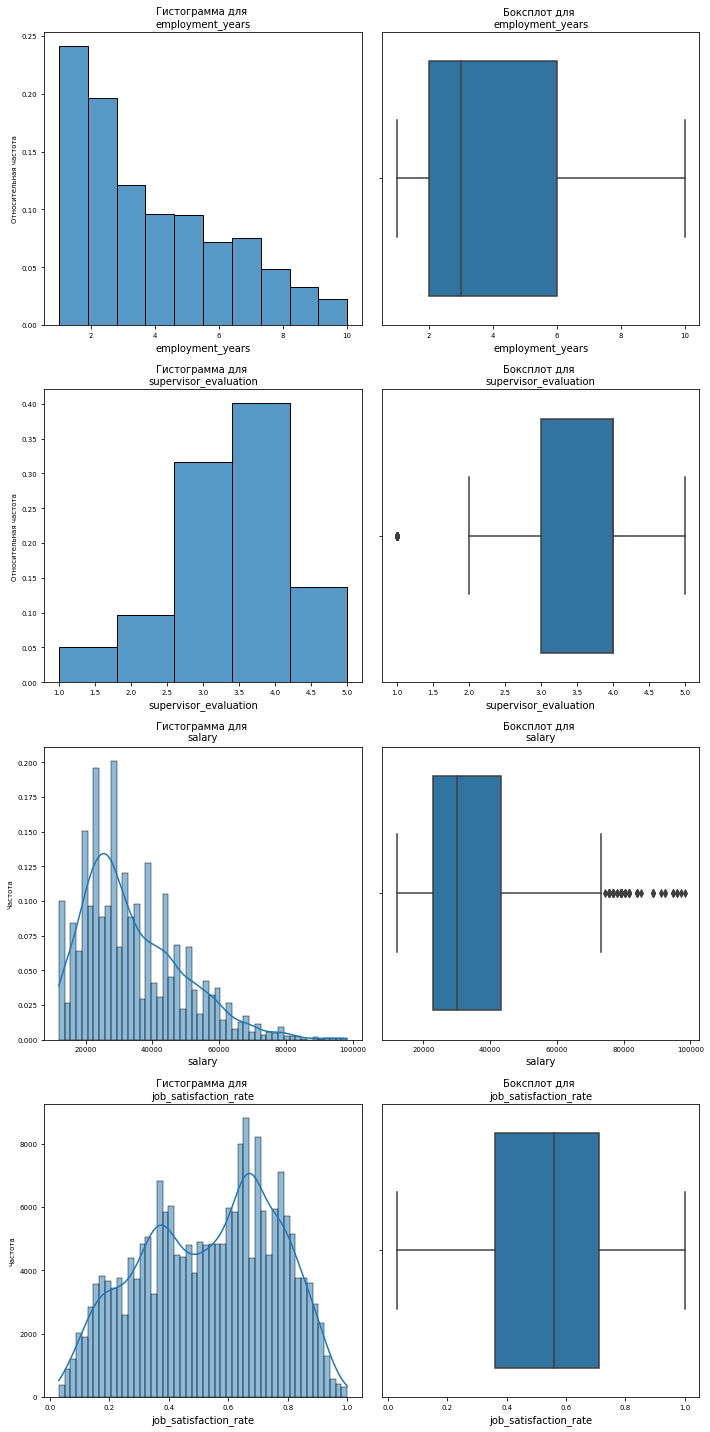

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [7]:
histbox(
    train_satisfaction_rate_df, 
    exclude_cols=['id'], 
    bins=50, 
    figsize=(10, 20), 
    title_fontsize=10, 
    axis_fontsize=7
)

train_satisfaction_rate_df.describe()

### Промежуточные выводы по распределению числовых признаков `train_satisfaction_rate_df`:

- **employment_years**: признак с дискретной природой. Больше всего сотрудников, которые работают один год в компании. Среднее 3.71, медиана 3, min 1, max 10.

- **supervisor_evaluation**: признак с дискретной природой. Больше всего сотрудников, чью работу оценивают на 4 из 5. Среднее 3.47, медиана 4, min 1, max 5.

- **salary**: ненормальное распределение со сдвигом влево, аномалий при близком рассмотрении не выявили, хоть боксплот и показывает потенциальные аномалии. Среднее 33926, медиана 30000, min 12000, max 98400.

- **job_satisfaction_rate**: ненормальное распределение со сдвигом вправо. Среднее 0.53, медиана 0.56, min 0.03, max 1.

Проведем исследовательский анализ категориальных данных в train_satisfaction_rate_df:

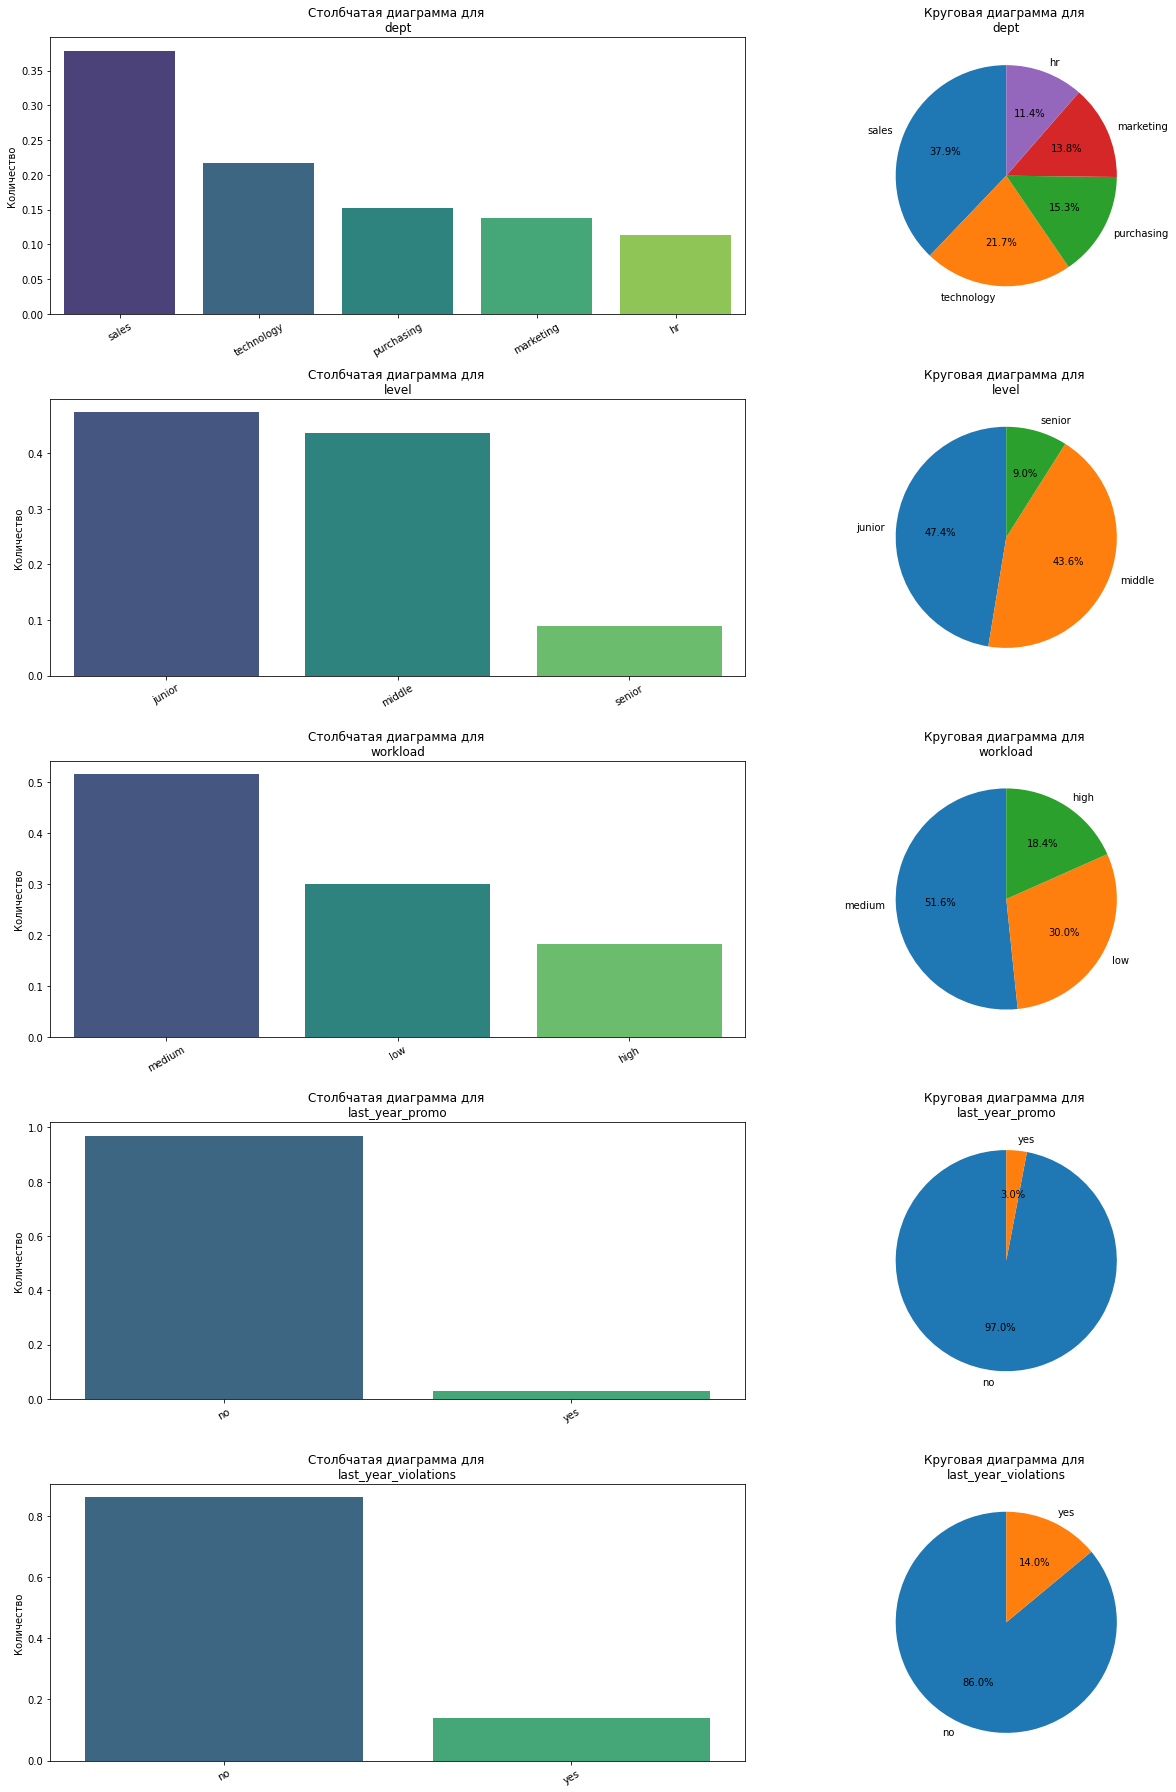

In [8]:
catplot(train_satisfaction_rate_df,  
    figsize=(19, 25), 
    title_fontsize=12, 
    axis_fontsize=10
)

### Промежуточные выводы по распределению категориальных признаков `train_satisfaction_rate_df`:

- **dept**: в датафрейме 37.9% сотрудников из продаж, 21.7% из ИТ, 15.3% из закупок, 13.8% из маркетинга и 11.4% из HR.

- **level**: в датафрейме 47.4% junior-специалисты, 43.6% middle и 9% senior-ы.

- **workload**: в датафрейме у 51.6% сотрудников средняя нагрузка, у 30% низкая и у 18.4% высокая.

- **last_year_promo**: в датафрейме у 3% сотрудников было повышение в прошлом году.

- **last_year_violations**: в датафрейме у 14% сотрудников были нарушения в прошлом году.

Проведем исследовательский анализ числовых данных в test_features_df:

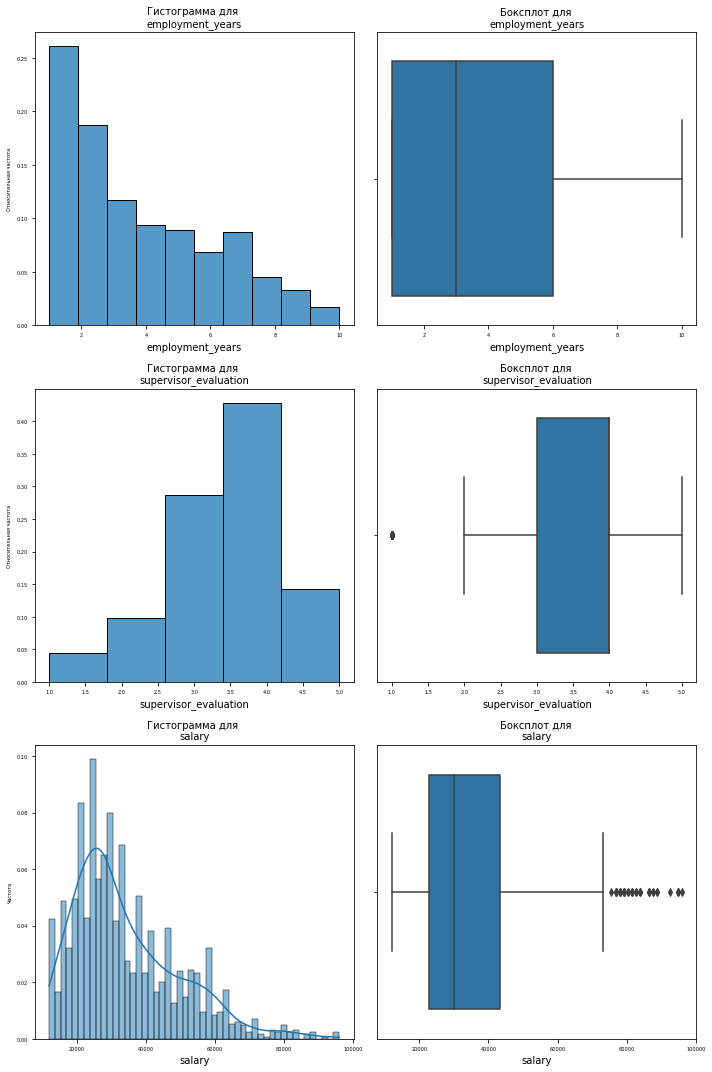

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [9]:
histbox(
    test_features_df, 
    exclude_cols=['id'], 
    bins=50, figsize=(10, 15), 
    title_fontsize=10, 
    axis_fontsize=5
)

test_features_df.describe() 

### Промежуточные выводы по распределению числовых признаков `test_features_df`:

- **employment_years**: признак с дискретной природой. Больше всего сотрудников, которые работают один год в компании. Среднее 3.66, медиана 3, min 1, max 10.

- **supervisor_evaluation**: признак с дискретной природой. Больше всего сотрудников, чью работу оценивают на 4 из 5. Среднее 3.52, медиана 4, min 1, max 5.

- **salary**: ненормальное распределение со сдвигом влево, аномалий при близком рассмотрении не выявили, хоть боксплот и показывает потенциальные аномалии. Среднее 34066, медиана 30000, min 12000, max 96000.

Проведем исследовательский анализ категориальных данных в test_features_df:

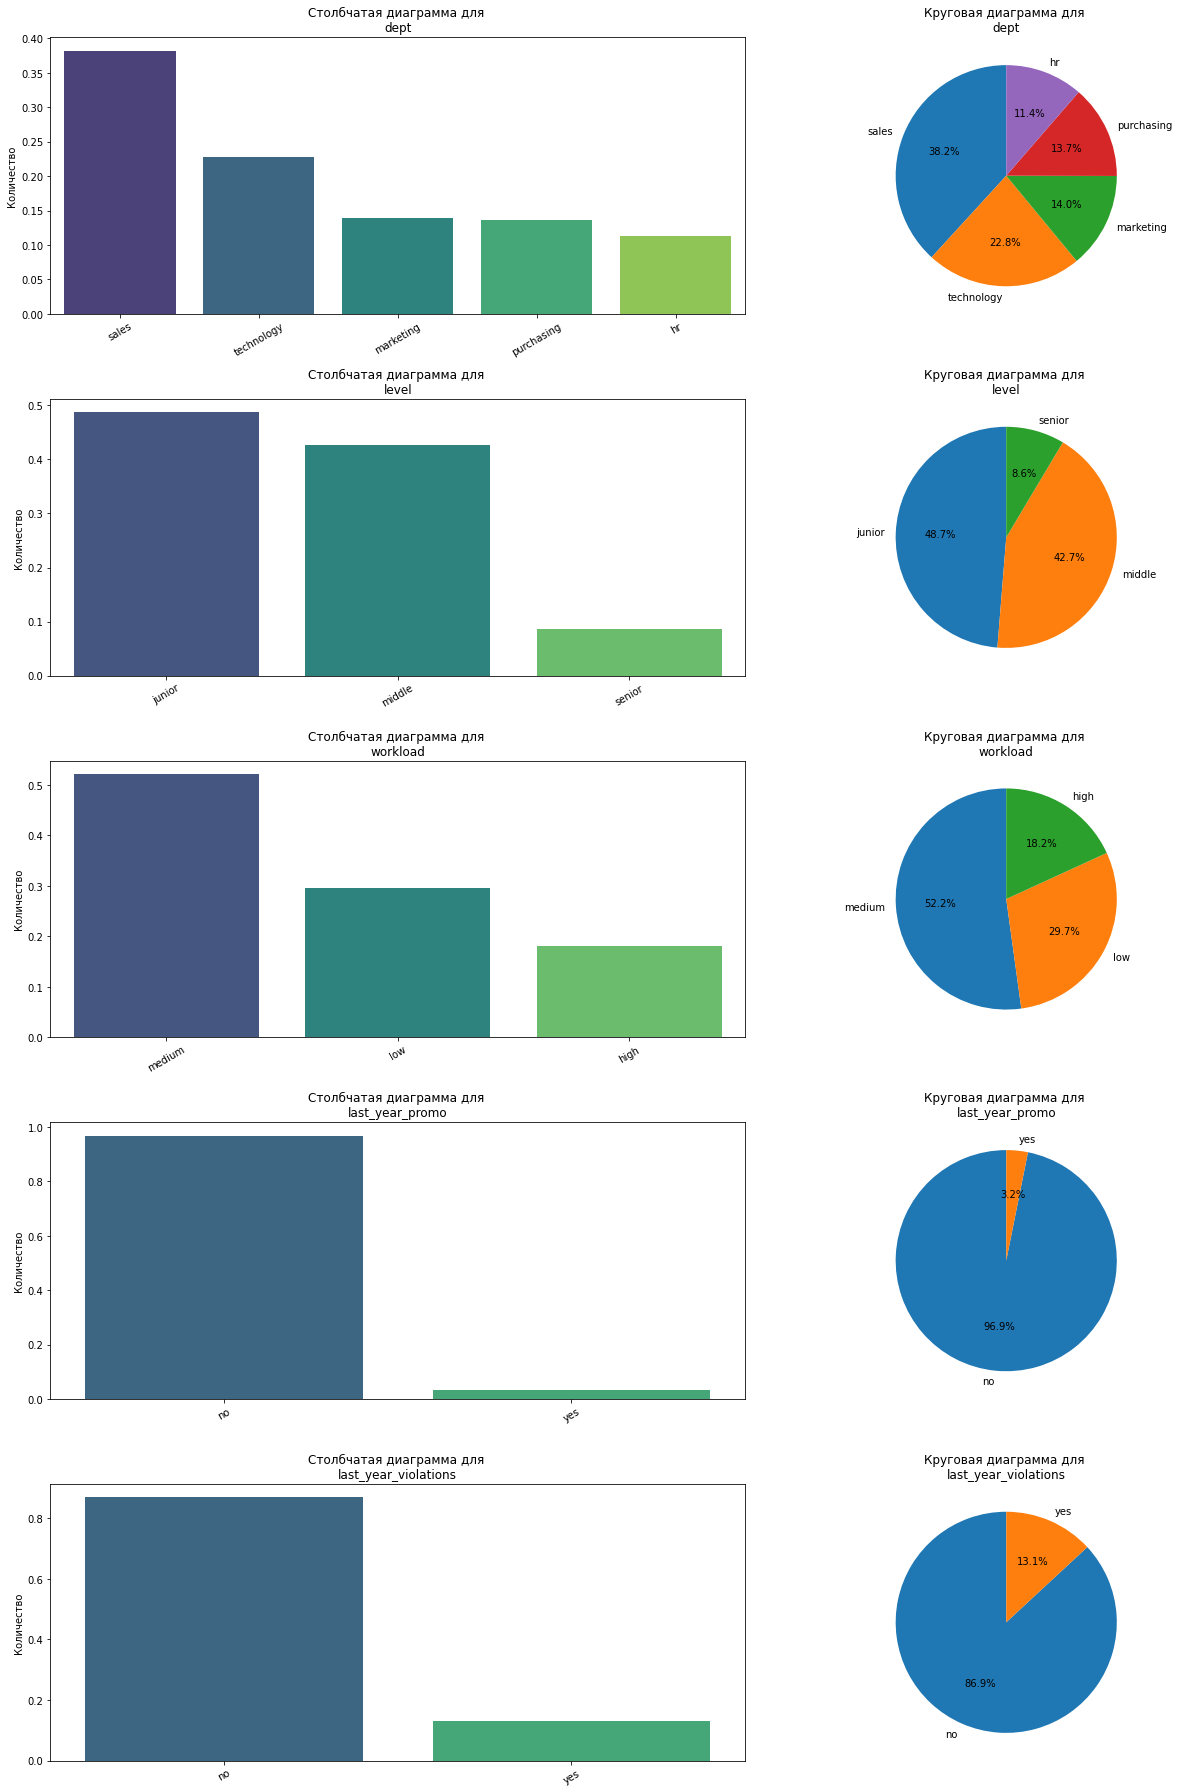

In [10]:
catplot(test_features_df,  
    figsize=(19, 25), 
    title_fontsize=12, 
    axis_fontsize=10
)

### Промежуточные выводы по распределению категориальных признаков `test_features_df`:

- **dept**: в датафрейме 38.2% сотрудников из продаж, 22.8% из ИТ, 14% из маркетинга, 13.7% из закупок и 11.4% из HR.

- **level**: в датафрейме 48.7% junior-специалисты, 42.7% middle и 8.6% senior-ы.

- **workload**: в датафрейме у 52.2% сотрудников средняя нагрузка, у 29.7% низкая и у 18.2% высокая.

- **last_year_promo**: в датафрейме у 3.2% сотрудников было повышение в прошлом году.

- **last_year_violations**: в датафрейме у 13.1% сотрудников были нарушения в прошлом году.

Проведем исследовательский анализ числовых данных в test_satisfaction_rate_df:

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


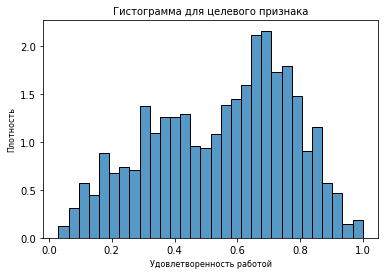

In [11]:
histplot = sns.histplot(test_satisfaction_rate_df['job_satisfaction_rate'], bins=30, stat='density')
histplot.set_title('Гистограмма для целевого признака', fontsize=10)
histplot.set_xlabel('Удовлетворенность работой', fontsize=8)
histplot.set_ylabel('Плотность', fontsize=8)

test_satisfaction_rate_df.describe()

### Промежуточные выводы по распределению числовых признаков `test_satisfaction_rate_df`:

- **job_satisfaction_rate**: признак распределен со сдвигом вправо. Среднее 0.54, медиана 0.58, min 0.03, max 1.

Перед подготовкой данных и обучением моделей используем библиотеку phik для подсчёта корреляции между признаками разных типов данных:

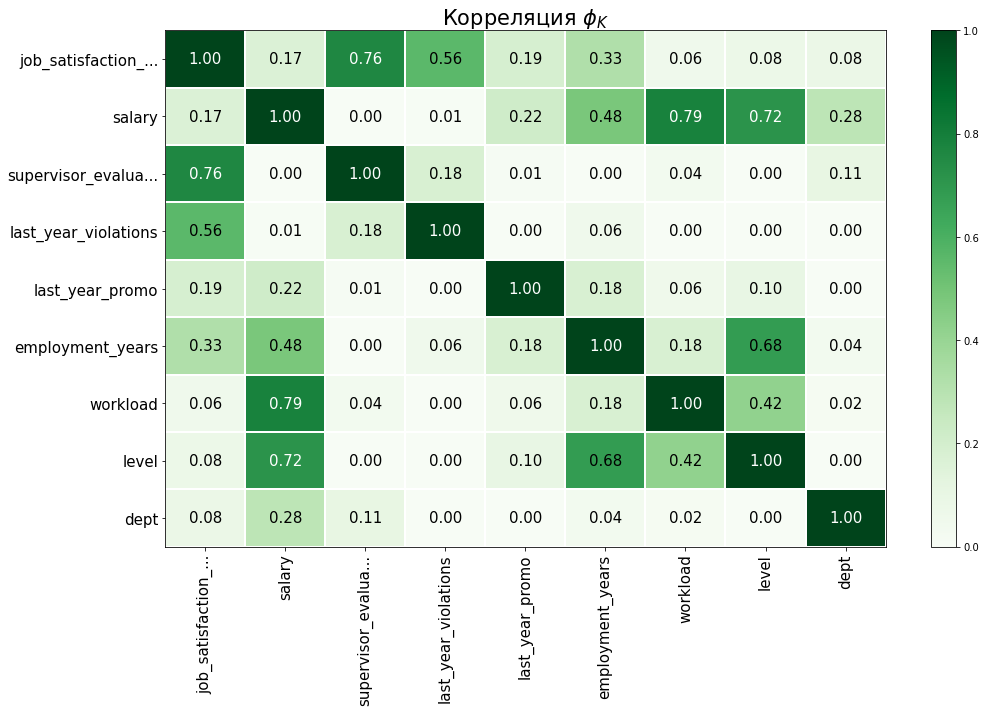

In [12]:
data_phik = train_satisfaction_rate_df.set_index('id')

interval_cols = ['salary', 'job_satisfaction_rate']

phik_analysis = (
    data_phik
    .phik_matrix(interval_cols = interval_cols, verbose=False))

# визуализируем матрицу и выводим на экран
plot_correlation_matrix(
    phik_analysis.values,
    x_labels=phik_analysis.columns,
    y_labels=phik_analysis.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

Видим, что утечки целевого признака в тренировочной выборке нет, так как корреляция с ним не превышает 0.9. Изучим, с какими входными признаками у него есть высокая корреляция:

- supervisor_evaluation: 0.76, высокая корреляция
- last_year_violation: 0.56, заметная корреляция

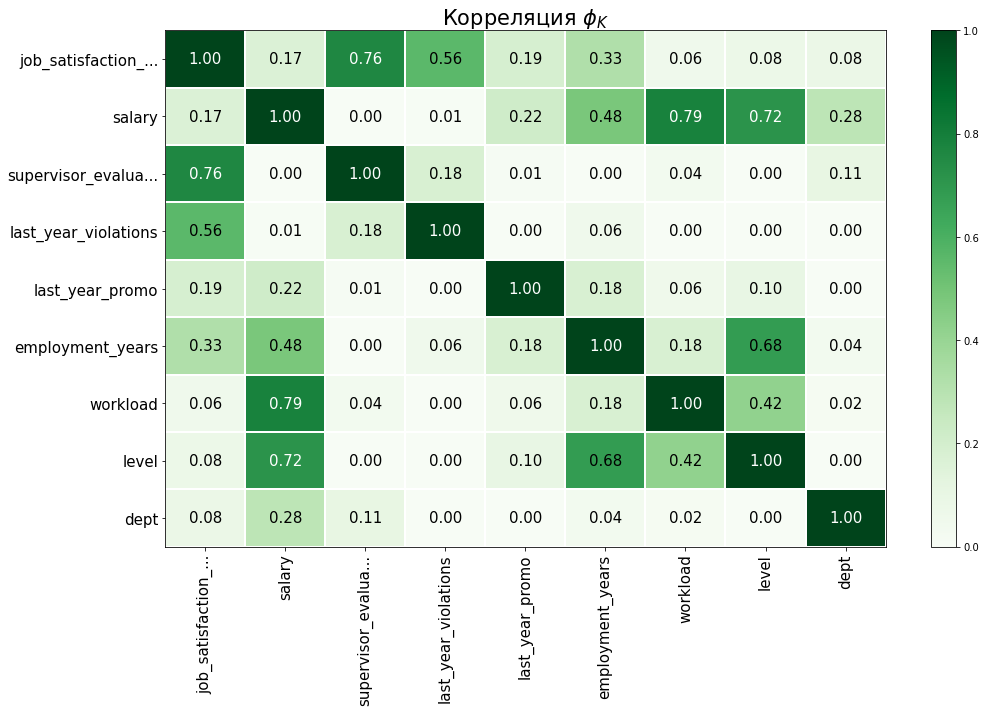

In [13]:
test_data_phik = test_features_df.merge(test_satisfaction_rate_df, on='id').set_index('id')

test_interval_cols = ['salary', 'job_satisfaction_rate']

phik_analysis_test = (
    test_data_phik
    .phik_matrix(interval_cols = test_interval_cols, verbose=False))

# визуализируем матрицу и выводим на экран
plot_correlation_matrix(
    phik_analysis.values,
    x_labels=phik_analysis.columns,
    y_labels=phik_analysis.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

В тестовой выборке также нет утечки целевого признака, так как корреляция с ним не превышает 0.9.

### Выводы:

Изучили, визуализировали и описали числовые и категориальные признаки в имеющихся датафреймах с помощью гистограмм, боксплотов, столбчатых и круговых диаграмм.

1. `train_satisfaction_rate_df`:

- **employment_years**: признак с дискретной природой. Больше всего сотрудников, которые работают один год в компании. Среднее 3.71, медиана 3, min 1, max 10.

- **supervisor_evaluation**: признак с дискретной природой. Больше всего сотрудников, чью работу оценивают на 4 из 5. Среднее 3.47, медиана 4, min 1, max 5.

- **salary**: ненормальное распределение со сдвигом влево, аномалий при близком рассмотрении не выявили, хоть боксплот и показывает потенциальные аномалии. Среднее 33926, медиана 30000, min 12000, max 98400.

- **job_satisfaction_rate**: ненормальное распределение со сдвигом вправо. Среднее 0.53, медиана 0.56, min 0.03, max 1.

- **dept**: в датафрейме 37.9% сотрудников из продаж, 21.7% из ИТ, 15.3% из закупок, 13.8% из маркетинга и 11.4% из HR.

- **level**: в датафрейме 47.4% junior-специалисты, 43.6% middle и 9% senior-ы.

- **workload**: в датафрейме у 51.6% сотрудников средняя нагрузка, у 30% низкая и у 18.4% высокая.

- **last_year_promo**: в датафрейме у 3% сотрудников было повышение в прошлом году.

- **last_year_violations**: в датафрейме у 14% сотрудников были нарушения в прошлом году.

2. `test_features_df`:

- **employment_years**: признак с дискретной природой. Больше всего сотрудников, которые работают один год в компании. Среднее 3.66, медиана 3, min 1, max 10.

- **supervisor_evaluation**: признак с дискретной природой. Больше всего сотрудников, чью работу оценивают на 4 из 5. Среднее 3.52, медиана 4, min 1, max 5.

- **salary**: ненормальное распределение со сдвигом влево, аномалий при близком рассмотрении не выявили, хоть боксплот и показывает потенциальные аномалии. Среднее 34066, медиана 30000, min 12000, max 96000.

- **dept**: в датафрейме 38.2% сотрудников из продаж, 22.8% из ИТ, 14% из маркетинга, 13.7% из закупок и 11.4% из HR.

- **level**: в датафрейме 48.7% junior-специалисты, 42.7% middle и 8.6% senior-ы.

- **workload**: в датафрейме у 52.2% сотрудников средняя нагрузка, у 29.7% низкая и у 18.2% высокая.

- **last_year_promo**: в датафрейме у 3.2% сотрудников было повышение в прошлом году.

- **last_year_violations**: в датафрейме у 13.1% сотрудников были нарушения в прошлом году.

3. `test_satisfaction_rate_df`:

- **job_satisfaction_rate**: признак распределен со сдвигом вправо. Среднее 0.54, медиана 0.58, min 0.03, max 1.

При подготовке категориальных данных будем использовать кодирование. Для признаков с нарушениями и повышениями можно взять метод OneHotEncoder, для остальных признаков OrdinalEncoder. 

Кроме того, с помощью библиотеки phik выявили, что утечки целевого признака нет.  

## Шаг 4. Подготовка данных

Вспомним, что по условию в пайплайне нам необходимо также обработать пропуски. Пропуски есть в колонках 'dept', level', 'workload'. Последние два мы кодируем с помощью OrdinalEncoder, который работает с ранговыми переменными: они являются ранговыми.

Масштабируем количественные признаки employment_years, supervisor_evaluation, salary.

dept, last_year_promo и last_year_violations закодируем с помощью OneHotEncoder.

Сперва подготовим тренировочную выборку train_satisfaction_rate_df: удалим id, проверим на кол-во дубликатов после удаления id, удалим их, разделим выборку на X_train и y_train. Дубликаты удаляем, так как они не повлияют на обучение и лишь потенциально замедлят его, а еще могут повлияют на распределение весов.

In [14]:
train_df = train_satisfaction_rate_df.drop(['id'], axis=1)
print('Количество дубликатов:',train_df.duplicated().sum())
train_df = train_df.drop_duplicates().reset_index(drop=True)

X_train = train_df.drop(['job_satisfaction_rate'], axis=1)
y_train = train_df['job_satisfaction_rate']
print(X_train.shape)
print(y_train.shape)

Количество дубликатов: 245
(3755, 8)
(3755,)


Объединим два датафрейма тестовой выборки и разделим их на входные и целевые признаки. 

In [15]:
test_df = test_features_df.merge(test_satisfaction_rate_df, on='id')
X_test = test_df.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = test_df['job_satisfaction_rate']
X_test.shape

(2000, 8)

Используем нашу функцию по подготовке пайплайна для обработки признаков с учетом условий, которые указали в описании плана по шагу. 

In [16]:
ohe_columns = [
    'last_year_violations', 
    'last_year_promo', 'dept'
]

ord_columns = [
    'level', 
    'workload'
]

num_columns = ['salary', 'employment_years', 
               'supervisor_evaluation']


ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

In [17]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

### Вывод: 

- Сперва мы подготовили тренировочную выборку train_satisfaction_rate_df: удалили id, появившиеся дубликаты, разделили выборку на X_train и y_train.
- Еще подготовили тестовую выборку: объединили два датафрейма, удалили id.
- С помощью OrdinalEncoder обработали 'level', 'workload'.
- dept, last_year_promo и last_year_violations закодировали с помощью OneHotEncoder.
- Масштабировали employment_years, supervisor_evaluation, salary.

## Шаг 5. Обучение моделей

Для решения задачи возьмем заданные по условию модели линейной регрессии и дерево решений с перебором гиперпараметров. У дерева решений зададим перебор таких параметров: максимальная глубина от 8 до 20, мминимального количества образцов в листе 5 и для разделения от 5 до 15. Это поможет уменьшить риск переобучения, поскольку гиперпараметры способны предотвратить слишком глубокое разветвление дерева.

Еще добавим к этим моделям KNN, чтобы оценить также его производительность в рамках задачи. 

Подготовим smape_scorer для использования метрики SMAPE с помощью ранее написанной функции def(smape) и make_scorer. 

In [18]:
smape_scorer = make_scorer(smape, greater_is_better=False)

In [19]:
param_grid = [
    
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE, max_features=11, min_samples_leaf=5)],
        'models__max_depth': [None] + [i for i in range(2, 7)],
        'models__min_samples_split': range(5,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
 
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
 
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
 
]

In [20]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,    
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=50
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['last_year_violations',
                                                                                'last_year_promo',
                                                                                'dept']),
                                                                              ('ord',
                                                                               Pip...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsRegressor()],
                                         'models__n_neighbors': range(2, 11),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False))

Посмотрим на лучшую модель и ее параметры, а заодно на метрику модели на кросс-валидации.

In [21]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_*-1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                            

Лучшая модель - дерево решений, которое применяется для задач регрессии, с максимальной глубиной в 18, min_samples_leaf 5, min_samples_split 13 и максимальным числом признаков в 11. Эта модель показала себя лучше всего из-за точной настройки гиперпараметров и поиска из довольно широкого списка, возможности уменьшения шума в данных из-за установки максимального числа признаков для разбиения.

Посмотрим, как она поведет себя на тестовой выборке, и посчитаем на ней нашу метрику. 

In [22]:
y_pred_test = randomized_search.best_estimator_.predict(X_test)
smape_test = smape(y_test, y_pred_test)
print ("Метрика SMAPE равна:", smape_test)

Метрика SMAPE равна: 13.591284245742886


Критерий успеха: SMAPE ≤ 15 на тестовой выборке. Значит, текущая модель успешно прошла тест.

Проверим модель на адекватность с помощью DummyRegressor(): для жтого сравним результаты Dummy с результатами на тестовой выборке.

In [23]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)
dummy_model_pred = dummy_model.predict(X_test)

dummy_smape_test = smape(y_test, dummy_model_pred)
print("Метрика SMAPE у Dummy равна:", dummy_smape_test)

Метрика SMAPE у Dummy равна: 38.26225790202237


Мы видим, что результат DummyRegressor по метрике SMAPE гораздо хуже по условиям задачи, чем у лучшей модели на тестовой выборке. Это значит, что от работы модели есть польза.

### Выводы по первой задаче: 

- Мы успешно загрузили три датафрейма, обнаружили пустые значения в категориальных признаках, обработали их и перевели в NaN, чтобы далее обработать пропуски в пайплайне. Явных дубликатов не обнаружили.


- Затем изучили, визуализировали и описали числовые и категориальные признаки в имеющихся датафреймах с помощью гистограмм, боксплотов, столбчатых и круговых диаграмм. Кроме того, с помощью библиотеки phik выявили, что утечки целевого признака нет.  


- Далее мы подготовили тренировочную выборку: удалили id, появившиеся дубликаты, разделили выборку на X_train и y_train. Еще подготовили тестовую выборку: объединили два датафрейма, удалили id.


- С помощью OrdinalEncoder обработали 'level', 'workload'. Dept, last_year_promo и last_year_violations закодировали с помощью OneHotEncoder. Масштабировали employment_years, supervisor_evaluation, salary.


- Нашли лучшую модель - дерево решений с min_samples_leaf 5, min_samples_split 13 и максимальным числом признаков в 11. Метрика SMAPE на тестовой выборке равна: 13.6

- Проверили адекватность модели, сравнив ее метрику SMAPE на тестовой выборке с показателями DummyRegressor(). Мы видим, что модель показывает гораздо лучшие результаты по сравнению с dummy-моделью.


- Эта модель показала себя лучше всего из-за точной настройки гиперпараметров и поиска из довольно широкого списка, возможности уменьшения шума в данных из-за установки максимального числа признаков для разбиения.

## Вторая задача
## Шаг 1. Загрузка и знакомство с данными

Загрузим и изучим данные, как в первой задаче, а test_features_df подтянем из первой задачи:

In [24]:
pth1_train_quit = 'https://code.s3.yandex.net/datasets/train_quit.csv'
pth2_train_quit = '/Users/macbookpro/Downloads/train_quit.csv'

if os.path.exists(pth2_train_quit):
    train_quit_df = pd.read_csv(pth2_train_quit, parse_dates=True)
else:
    try:
        urlretrieve(pth1_train_quit, pth2_train_quit)
        train_quit_df = pd.read_csv(pth2_train_quit, parse_dates=True)
    except Exception as e:
        print('Something is wrong:', e)

pth1_test_target_df = 'https://code.s3.yandex.net/datasets/test_target_quit.csv'
pth2_test_target_df = '/Users/macbookpro/Downloads/test_target_quit.csv'
   
if os.path.exists(pth2_test_target_df):
    test_target_df = pd.read_csv(pth2_test_target_df, parse_dates=True)
else:
    try:
        urlretrieve(pth1_test_target_df, pth2_test_target_df)
        test_target_df = pd.read_csv(pth2_test_target_df, parse_dates=True)
    except Exception as e:
        print('Something is wrong:', e)

In [25]:
all_df_quit = [train_quit_df, test_features_df, test_target_df]

quick_info(all_df_quit)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None
Статистика по числовым данным:
                  id  employment_years  supervisor_evaluation        salary
count    4000.000000       4000.000000            4000.000000   4000.000000
mean   552099.283750   

### Выводы:

`train_quit_df`:

- В датафрейме 10 колонок, названия которых приведены к "змеиному" регистру, и 4000 строк. Мы видим, что пропусков пока невидно.
- Данные датафрейма соответствуют своему типу.
- Наученные опытом первой задачи, высокие показатели salary за выброс не считаем.

`test_features_df`:

- В датафрейме 9 колонок, названия которых приведены к "змеиному" регистру, и 2000 строк. Мы видим, что пропуски есть в признаках `dept` и `level`. 
- Данные датафрейма соответствуют своему типу.
- Аналогично с выбросами.

`test_target_df`:

- В датафрейме 2 колонки, названия которых приведены к "змеиному" регистру, и 2000 строк.
- Данные датафрейма соответствуют своему типу.
- Возможные выбросы не отслеживаются.

## Шаг 2. Предобработка данных

In [26]:
print_unique_values([train_quit_df], 
                    ['dept', 'level', 'workload', 
                         'last_year_promo', 'last_year_violations'])
print_unique_values([test_target_df], ['quit'])

Уникальные значения столбца 'dept' в датафрейме 1:
['hr' 'marketing' 'purchasing' 'sales' 'technology']
Уникальные значения столбца 'level' в датафрейме 1:
['junior' 'middle' 'sinior']
Уникальные значения столбца 'workload' в датафрейме 1:
['high' 'low' 'medium']
Уникальные значения столбца 'last_year_promo' в датафрейме 1:
['no' 'yes']
Уникальные значения столбца 'last_year_violations' в датафрейме 1:
['no' 'yes']
Уникальные значения столбца 'quit' в датафрейме 1:
['no' 'yes']


NaN-значений и пустых строк в новых датафреймах нет. Видим, что снова есть 'sinior': исправим на 'senior'.

In [27]:
train_quit_df = train_quit_df.replace('sinior', 'senior', regex=True)

### Выводы

- Проверили, есть ли пустые значения в категориальных признаках всех изученных датафреймов. Их нет.
- Поправили опечатку 'sinior' на 'senior'.
- Неявных дубликатов не обнаружили.

## Шаг 3. Исследовательский анализ данных

Изучим на всякий случай только train_quit_df и новый целевой признак в test_target_df, тк остальные признаки уже изучали ранее в первой задаче:

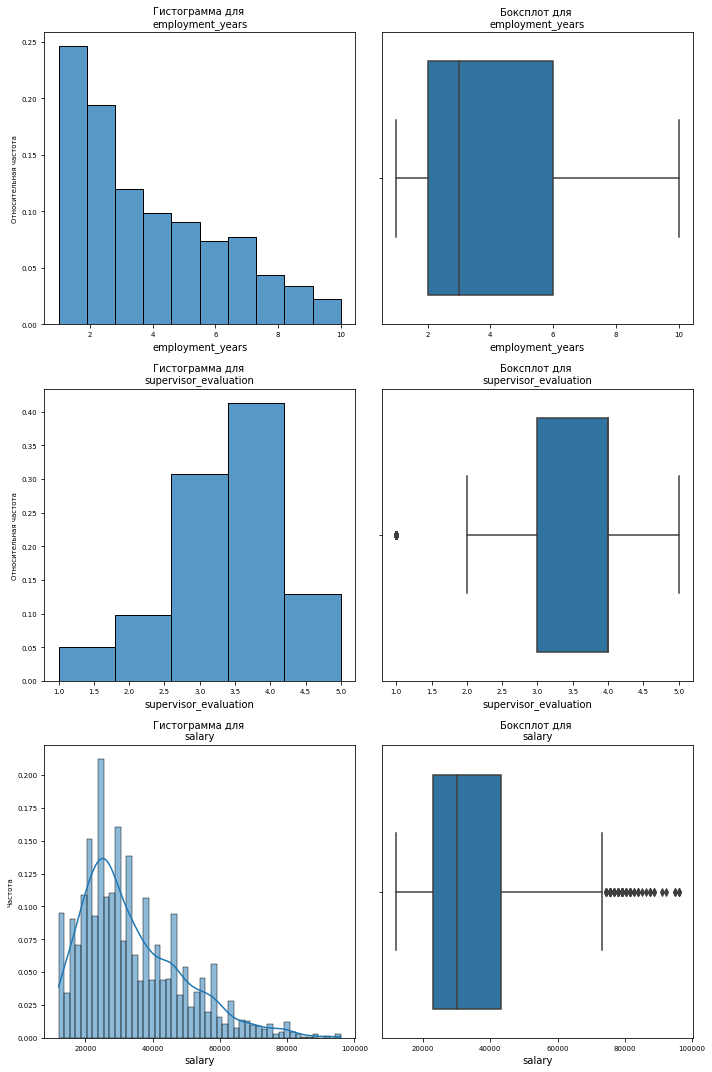

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [28]:
histbox(
    train_quit_df, 
    exclude_cols=['id'], 
    bins=50, figsize=(10, 15), 
    title_fontsize=10, 
    axis_fontsize=7
)

train_quit_df.describe()

### Промежуточные выводы по распределению числовых признаков `train_quit_df`:

- **employment_years**: признак с дискретной природой. Больше всего сотрудников, которые работают один год в компании, как в первой задаче. Среднее 3.7, медиана 3, min 1, max 10.

- **supervisor_evaluation**: признак с дискретной природой. Больше всего сотрудников, чью работу оценивают на 4 из 5. Среднее 3.47, медиана 4, min 1, max 5.

- **salary**: ненормальное распределение со сдвигом влево, аномалий при близком рассмотрении не выявили, хоть боксплот и показывает потенциальные аномалии. Среднее 33805, медиана 30000, min 12000, max 96000.

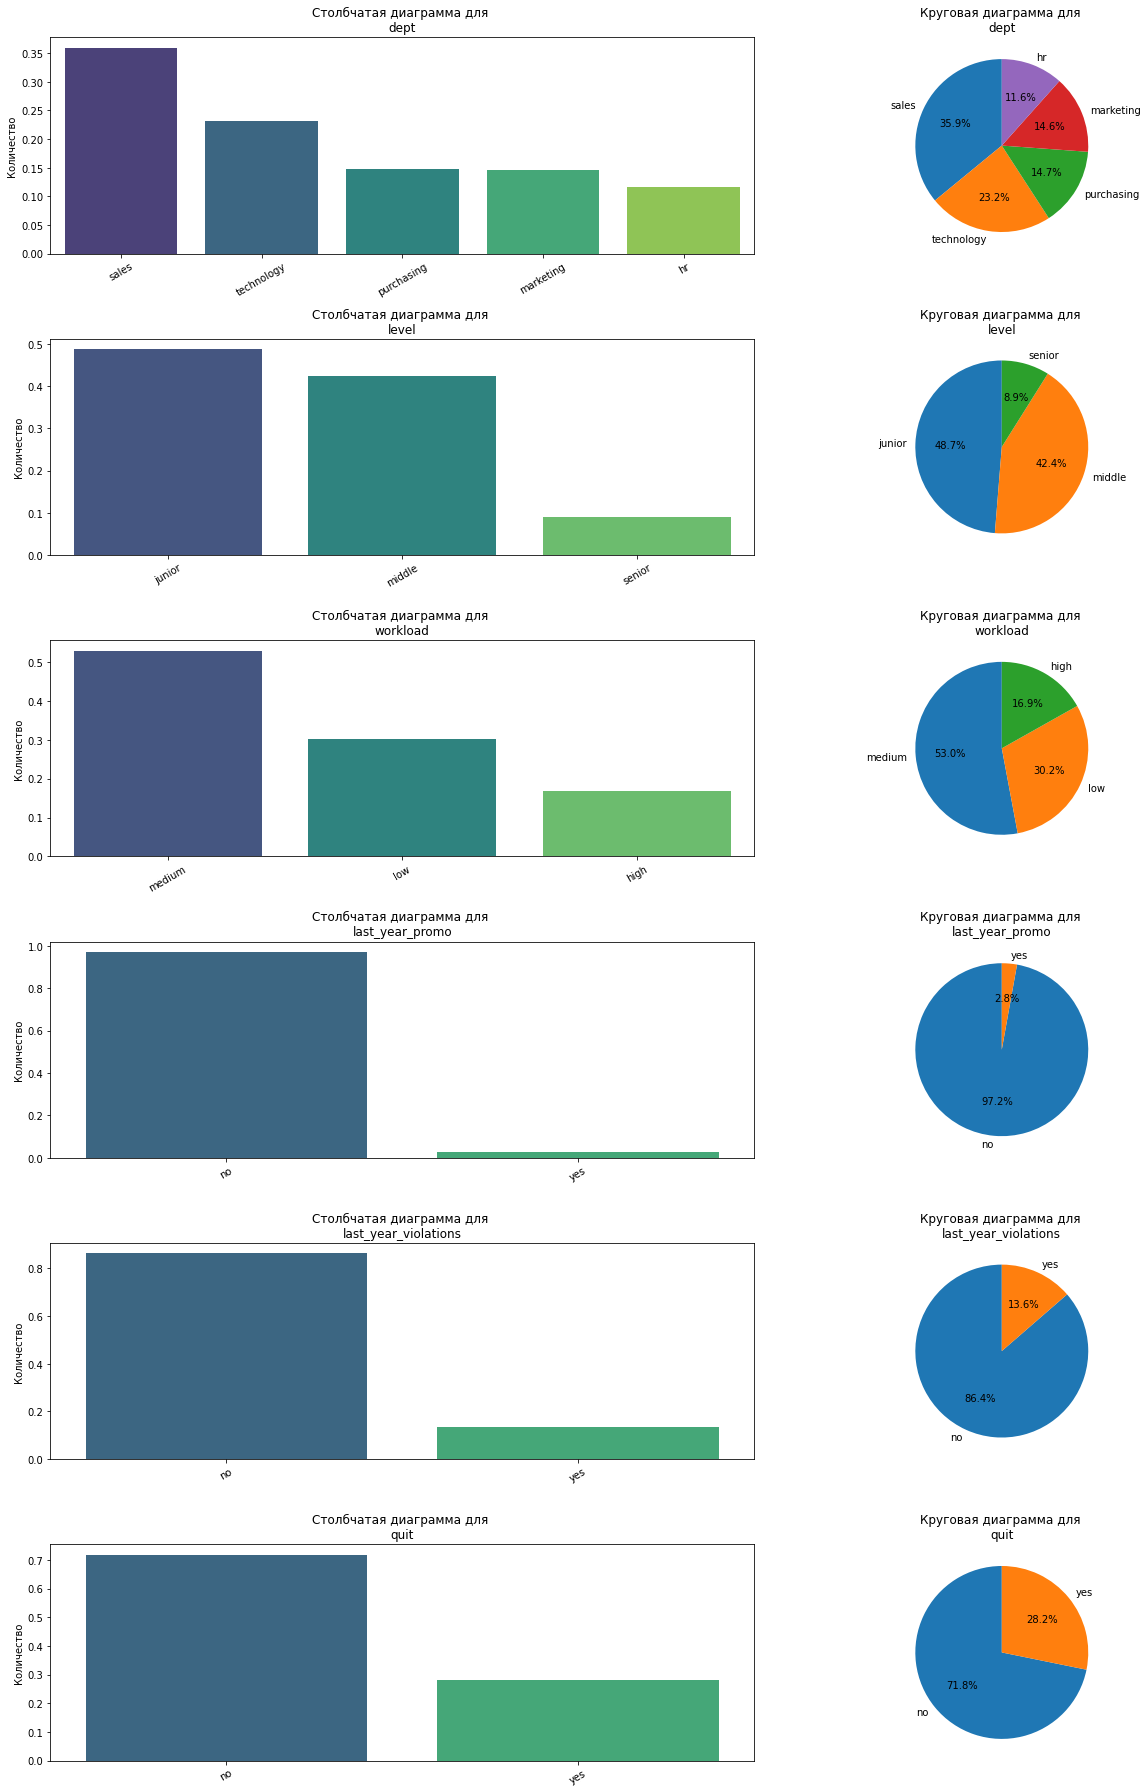

In [29]:
catplot(train_quit_df,  
    figsize=(19, 25), 
    title_fontsize=12, 
    axis_fontsize=10
)

### Промежуточные выводы по распределению категориальных признаков `train_quit_df`:

- **dept**: в датафрейме 35.9% сотрудников из продаж, 23.2% из ИТ, 14.7% из закупок, 14.6% из маркетинга и 11.6% из HR.

- **level**: в датафрейме 48.7% junior-специалисты, 42.4% middle и 8.9% senior-ы.

- **workload**: в датафрейме у 53% сотрудников средняя нагрузка, у 30.2% низкая и у 16.9% высокая.

- **last_year_promo**: в датафрейме у 2.8% сотрудников было повышение в прошлом году.

- **last_year_violations**: в датафрейме у 13.6% сотрудников были нарушения в прошлом году.

- **quit**: 28.2% были уволены или уволились

Посмотрим на категориальный признак test_target_df.

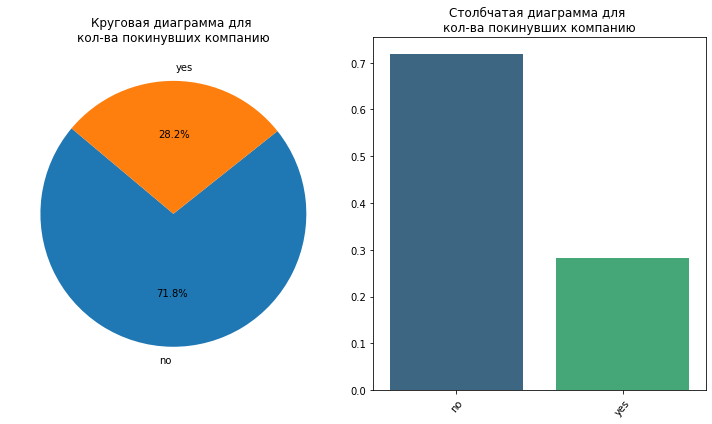

In [30]:
data_counts = test_target_df['quit'].value_counts(normalize=True)
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

axes[0].pie(data_counts, labels=data_counts.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Круговая диаграмма для \nкол-ва покинувших компанию')

sns.barplot(x=data_counts.index, y=data_counts.values, ax=axes[1], palette='viridis')
axes[1].set_title('Столбчатая диаграмма для \nкол-ва покинувших компанию')
axes[1].tick_params(axis='x', rotation=50)

plt.tight_layout()
plt.show()

В тренировочной и тестовой выборках число уволенных сотрудников примерно одинаковое. Классы несбалансированы. Из-за этого подойдет в качестве метрик моделей ROC AUC: она нечувствительна к дисбалансу, в отличие, например, от accuracy, precision, recall. Еще могла бы быть F1 Score, тк она тоже хороша работает с дисбалансами.

Попробуем составить портрет уволившегося сотрудника:

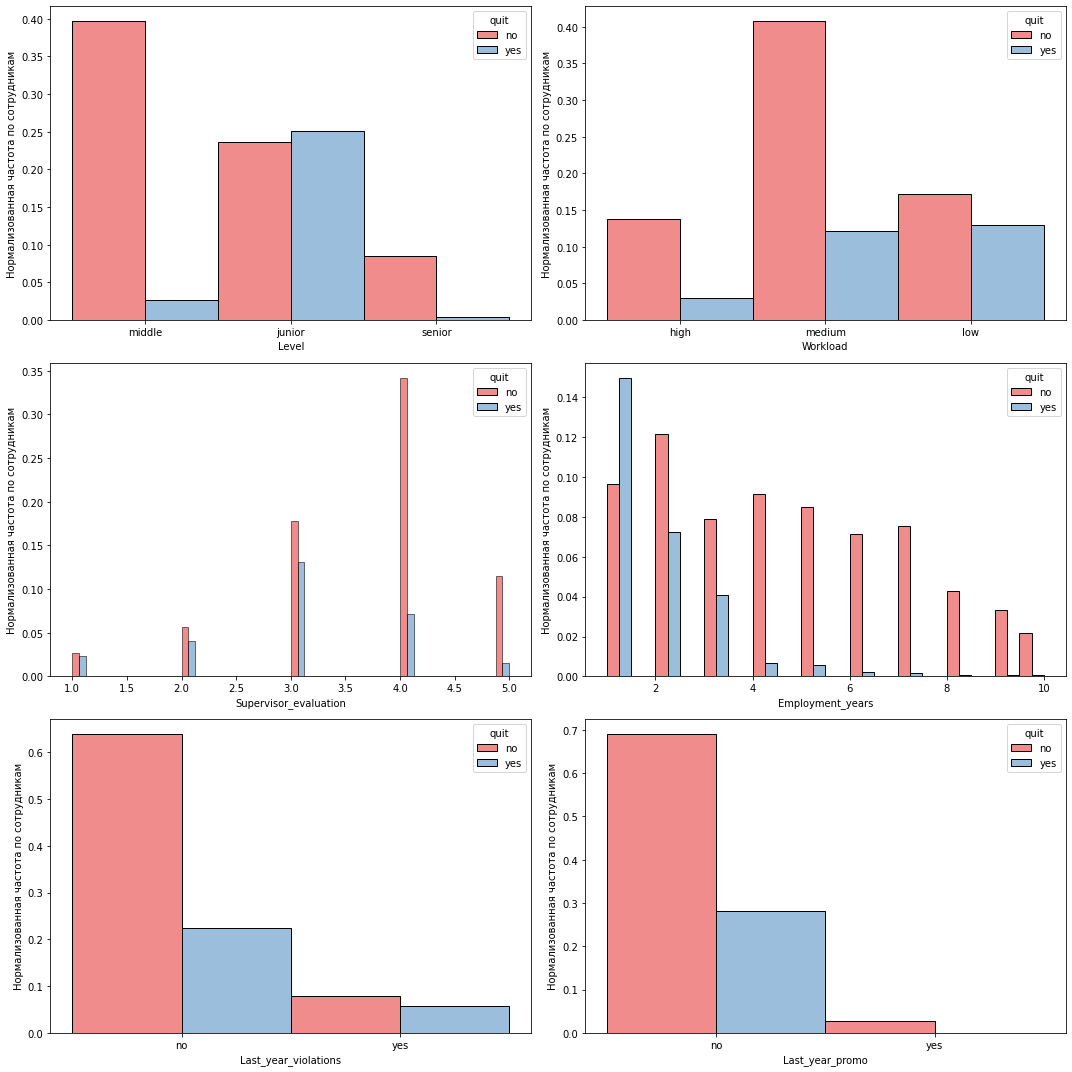

In [31]:
columns_to_plot = ['level', 'workload', 'supervisor_evaluation', 
                   'employment_years', 'last_year_violations',
                   'last_year_promo']

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

for i, column in enumerate(columns_to_plot):
    sns.histplot(x=column, data=train_quit_df, hue='quit', palette='Set1', alpha=0.5, 
                 ax=axes[i//2, i%2], stat='probability', multiple='dodge')
    axes[i//2, i%2].set(xlabel=column.capitalize(), ylabel='Нормализованная частота по сотрудникам')

plt.tight_layout()
plt.show()

### Промежуточные выводы по портрету уволившегося сотрудника:

- Больше всего увольняются сотрудники с уровнем должности junior. Это, конечно, объясняется и тем, что сотрудников этого грейда больше других;

- Интересно, но чаще других увольняются сотрудники с низкой загрузкой: гораздо чаще тех, кто перегружен;

- Чаще других увольняются специалисты, которым ревьюер поставил тройку: напомним, что наиболее частотная оценка 4;

- С годами работы в компании количество уволившихся сотрудников снижается. Чаще всего из компании уходят на 1-3 году работы.

- Чаще увольняются те, кто не нарушал договор: но их в датафрейме гораздо больше тех, кто нарушал. То же касается и повышений: тех, кого повысили, в датафрейме очень мало, выводы здесь делать тяжело (как и оценить влияние признака на целевой).

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение, но сперва добавим в датафрейм тестовой выборки признак удовлетворенности работой и проверим их на корреляцию.

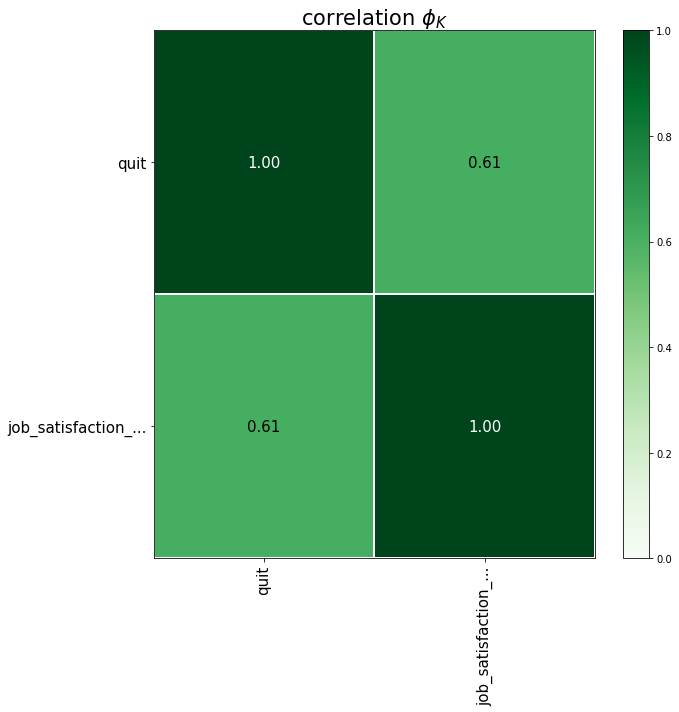

In [32]:
hypo_df = test_satisfaction_rate_df.merge(test_target_df, on='id')
hypo_df = hypo_df.set_index('id')
interval_cols = ['job_satisfaction_rate']
phik_overview = phik_matrix(hypo_df,interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 10)
)

Видим, что есть заметная корреляция между двумя признаками: увольнением и уровнем удовлетворенности работой. Поэтому на следующем шаге добавим его в тестовую и тренировочную выборки. Посмотрим еще корреляцию целевого с другими признаками на тренировочной выборке.

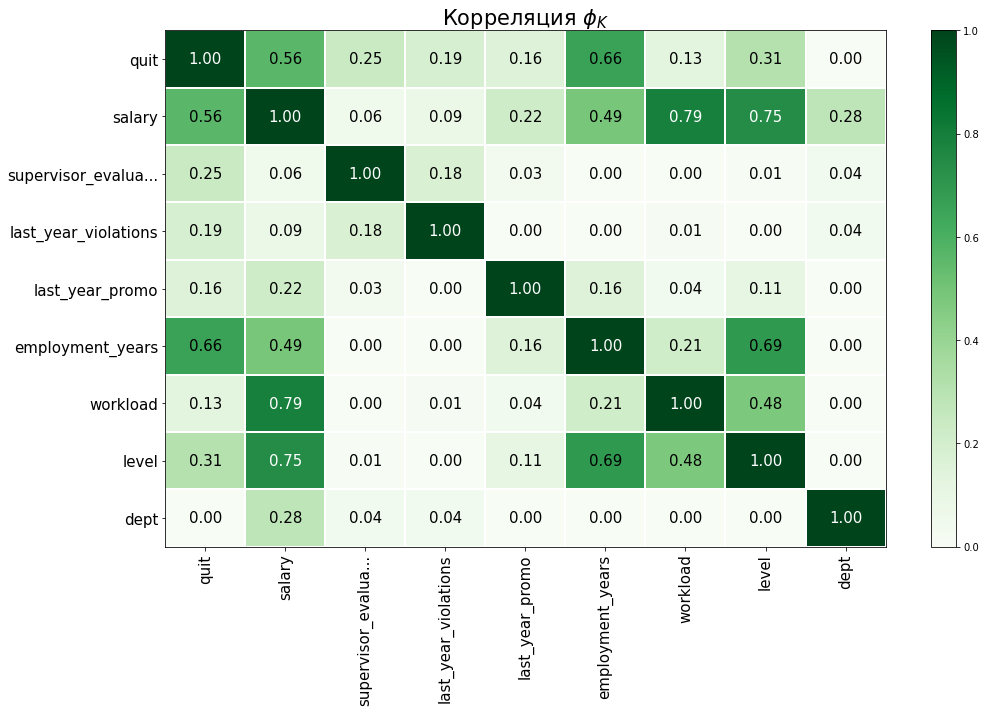

In [33]:
data_phik = train_quit_df.set_index('id')

interval_cols = ['salary', 'job_satisfaction_rate']

phik_analysis = (
    data_phik
    .phik_matrix(interval_cols = interval_cols, verbose=False))

# визуализируем матрицу и выводим на экран
plot_correlation_matrix(
    phik_analysis.values,
    x_labels=phik_analysis.columns,
    y_labels=phik_analysis.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

Видим, что есть заметная корреляция увольнения и:

- трудового стажа в компании: 0.66
- зарплаты: 0.56

Посмотрим также на распределение job_satisfaction_rate для ушедших и оставшихся сотрудников.

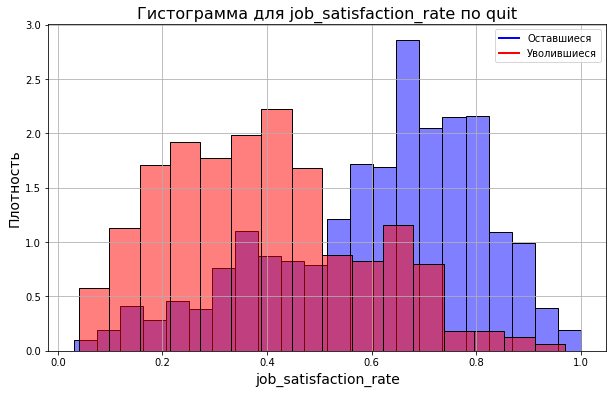

In [34]:
plot_histplot(hypo_df, 'job_satisfaction_rate', 'quit')

Мы видим, что метрика удовлетворенности работой у сотрудников, которые уволились, сдвинута влево. У них гораздо чаще есть показатели метрики от 0.2 до 0.6, чем у тех, кто остался в компании. При этом метрика сдвинута вправо у сотрудников, которые остались, с пиковым значением, близким к 0.7.

### Выводы

- признак **quit**: 28.2% были уволены или уволились

- портрет покинувшего компанию сотрудника: junior-специалист с низкой загрузкой, получивший от ревьюера три балла, который работал в компании не более трех лет.

- есть заметная корреляция между увольнением и уровнем удовлетворенности работой. еще заметна корреляция увольнения с трудовым стажем в компании и зарплатой.

- метрика удовлетворенности работой у сотрудников, которые уволились, сдвинута влево. У них гораздо чаще есть показатели метрики от 0.2 до 0.6, чем у тех, кто остался в компании. При этом метрика сдвинута вправо у сотрудников, которые остались, с пиковым значением, близким к 0.7.

## Шаг 4. Добавление нового входного признака

Добавляем прогноз job_satisfaction_rate в тренировочную и тестовую выборки, используя лучшую модель из первой задачи:

In [35]:
test_features_df['job_satisfaction_rate_pred'] = randomized_search.best_estimator_.predict(X_test)
test_features_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.845714
1,686555,hr,junior,medium,1,no,no,4,30000,0.676667
2,467458,sales,middle,low,5,no,no,4,19200,0.697778
3,418655,sales,middle,low,6,no,no,4,19200,0.697778
4,789145,hr,middle,medium,5,no,no,5,40800,0.825556


In [36]:
train_quit_df['job_satisfaction_rate_pred'] = randomized_search.best_estimator_.predict(
    train_quit_df.drop(['quit'], axis=1))
train_quit_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.645000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.838000
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.351111
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.791667


### Выводы

- Мы использовали лучшую модель из первой задачи, чтобы добавить прогноз job_satisfaction_rate в тренировочную и тестовую выборки;

- Убрали из тренировочной выборки целевой признак, чтобы избежать утечки при прогнозах

## Шаг 5. Подготовка данных

Подготовка данных будет аналогична первой задаче, но целевой признак обработаем LabelEncoder, тк он теперь категориальный. Прогноз удовлетворенности работой масштабируем вместе с другими количественными признаками.

In [37]:
train_quit_df = train_quit_df.drop(['id'], axis=1)
print('Количество дубликатов:',train_quit_df.duplicated().sum())
train_quit_df = train_quit_df.drop_duplicates().reset_index(drop=True)

X_train = train_quit_df.drop(['quit'], axis=1)
y_train_quit = train_quit_df['quit']
print(X_train.shape)
print(y_train_quit.shape)

test_quit_df = test_features_df.merge(test_target_df, on='id')
X_test = test_quit_df.drop(['id', 'quit'], axis=1)
y_test_quit = test_quit_df['quit']
print(X_test.shape)
print(y_test_quit.shape)

Количество дубликатов: 1413
(2587, 9)
(2587,)
(2000, 9)
(2000,)


In [38]:
label_encoder = LabelEncoder()
y_train_le = label_encoder.fit_transform(y_train_quit)
y_test_le = label_encoder.transform(y_test_quit)

In [39]:
ohe_columns_quit = [
    'last_year_violations', 
    'last_year_promo', 'dept'
]

ord_columns_quit = [
    'level', 
    'workload'
]

num_columns_quit = ['salary', 'employment_years', 
               'supervisor_evaluation', 'job_satisfaction_rate_pred']


ohe_pipe_quit = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
    )

ord_pipe_quit = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe_quit, ohe_columns_quit),
     ('ord', ord_pipe_quit, ord_columns_quit),
     ('num', MinMaxScaler(), num_columns_quit)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

### Вывод: 

- Сперва мы подготовили тренировочную выборку train_quit_df: удалили id, появившиеся дубликаты, разделили выборку на X_train и y_train_quit.
- Еще подготовили тестовую выборку: объединили два датафрейма, удалили id.
- Закодировали целевой признак с помощью LabelEncoder()
- С помощью OrdinalEncoder обработали 'level', 'workload'.
- dept, last_year_promo и last_year_violations закодировали с помощью OneHotEncoder.
- Масштабировали employment_years, supervisor_evaluation, salary и job_satisfaction_rate_pred.

## Шаг 6. Обучение моделей

Чтобы определить, уволится ли сотрудник или нет, нужно решить задачу бинарной классификации. Для нее будем тестировать и обучать в пайплайне модели логистической регрессии, KNN и дерева решений. За метрику возьмем ROC-AUC: она нечувствительна к дисбалансу классов, в отличие, например, от accuracy, precision, recall. 

Вот какие гиперпараметры будем тестировать:
- Дерево решений: максимальная глубина от None до 6, мминимальное количество образцов в листе 5, для разделения - от 5 до 15. 
- KNN: число соседей от 2 до 10
- Логистическая регрессия: регуляризация L1.

In [40]:
param_grid = [
    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, max_features=11, min_samples_leaf=5)],
        'models__max_depth': [None] + [i for i in range(2, 7)],
        'models__min_samples_split': range(2,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train_le)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['last_year_violations',
                                                                                'last_year_promo',
                                                                                'dept']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImp...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

In [41]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                       

Лучшая модель - логистическая регрессия с C3, L1-регуляризацией. Эта модель пока показала себя лучше всего из-за того, что хорошо подходит для задач бинарной классификации, а L1-регуляризация влияет на результативный отбор важных факторов для прогнозирования.

In [43]:
dummy_model_2 = DummyClassifier(random_state=RANDOM_STATE)
dummy_model_2.fit(X_train, y_train_le)
dummy_model_2_preds = dummy_model_2.predict(X_test)
dummy_model_2_probas = dummy_model_2.predict_proba(X_test)[:, 1]

#посчитаем метрику ROC-AUC
dummy_roc_2 = roc_auc_score(y_test_le, dummy_model_2_probas)
print('ROC-AUC =', round(dummy_roc_2,2))

#посчитаем F1-меру
dummy_f1_2 = f1_score(y_test_le, dummy_model_2_preds, pos_label=1)
print('F1-score =', round(dummy_f1_2,2))

ROC-AUC = 0.5
F1-score = 0.0


Сравним метрики dummy-модели с нашей пока лучшей моделью логистической регрессии. Мы видим, что ROC-AUC и F1-мера у логистической регрессии гораздо выше, а значит, она работает адекватно. Попробуем улучшить модель: для этого посмотрим на вклад признаков по shap.

PermutationExplainer explainer: 2001it [00:34, 42.77it/s]                       


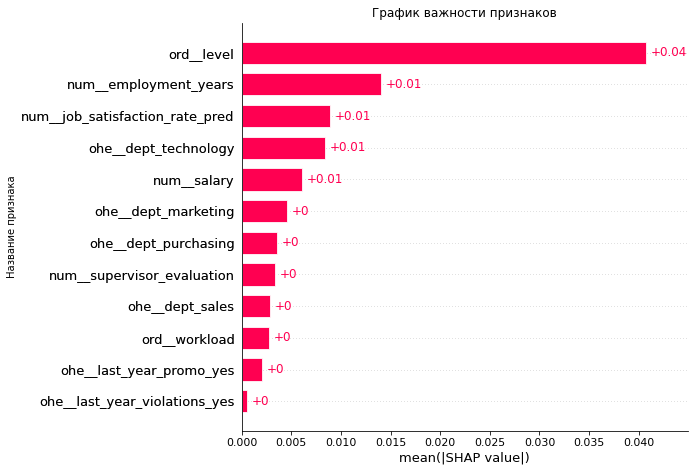

In [44]:
X_train_transformed = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_transformed = pipe_final.named_steps['preprocessor'].transform(X_test)

explainer = shap.PermutationExplainer(
    randomized_search.best_estimator_.named_steps['models'].predict_proba, X_test_transformed)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
explainer.feature_names = feature_names
shap_values_ = explainer(X_test_transformed)
shap.plots.bar(shap_values_[:,:,1], max_display=16, show=False)
plt.ylabel('Название признака')
plt.title('График важности признаков')
plt.show()

Видим, что для нашей модели оказались наиболее важны признаки level, employment_years, прогноз по удовлетворенности работой. Кажется, мало влияют на модель повышение сотрудника, его департамент, нарушения трудового договора. Отбросим их:

In [45]:
X_train_new = X_train.drop(['last_year_promo','last_year_violations', 'dept'], axis=1)
X_train_new.shape

(2587, 6)

In [46]:
ohe_columns_new = []

ord_columns_new = [
    'level', 
    'workload' 
]
num_columns_new = ['salary', 
               'employment_years', 'supervisor_evaluation', 
               'job_satisfaction_rate_pred'] 


ohe_pipe_quit_new = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
    )

ord_pipe_quit_new = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe_quit_new, ohe_columns_new),
     ('ord', ord_pipe_quit_new, ord_columns_new),
     ('num', MinMaxScaler(), num_columns_new)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_new = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, max_features=11)],
        'models__max_depth': [None] + [i for i in range(2, 8)],
        'models__min_samples_split': range(2,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    }
]

randomized_search_new = RandomizedSearchCV(
    pipe_final_new, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_new.fit(X_train_new, y_train_le)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               []),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='most_f...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

In [47]:
randomized_search_new = RandomizedSearchCV(
    pipe_final_new, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_new.fit(X_train_new, y_train_le)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               []),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='most_f...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

In [48]:
print('Лучшая модель и её параметры:\n\n', randomized_search_new.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search_new.best_score_)

y_test_proba_new = randomized_search_new.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_le, y_test_proba_new)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  []),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                              

In [49]:
dummy_model_3 = DummyClassifier(random_state=RANDOM_STATE)
dummy_model_3.fit(X_train_new, y_train_le)
dummy_model_3_preds = dummy_model_3.predict(X_test)
dummy_model_3_probas = dummy_model_3.predict_proba(X_test)[:, 1]

#посчитаем метрику ROC-AUC
dummy_roc_3 = roc_auc_score(y_test_le, dummy_model_3_probas)
print('ROC-AUC =', round(dummy_roc_3,2))

#посчитаем F1-меру
dummy_f1_3 = f1_score(y_test_le, dummy_model_3_preds, pos_label=1)
print('F1-score =', round(dummy_f1_3,2))

ROC-AUC = 0.5
F1-score = 0.0


Сравним метрики dummy-модели с лучшей моделью: ROC-AUC и F1-мера у дерева решений гораздо выше, а значит, она работает адекватно. 

Как видно, мы добились небольшого улучшения ROC-AUC на тестовой выборке c помощью отбора признаков. Финальной лучшей моделью стало дерево решений с максимальной глубиной в 4, min_samples_split 14 и максимальным числом признаков в 11. Эта модель показала себя лучше всего из-за точной настройки гиперпараметров и поиска из довольно широкого списка, возможности уменьшения шума в данных из-за установки максимального числа признаков для разбиения.

### Выводы:
    
- Проверили, есть ли пустые значения в категориальных признаках всех изученных датафреймов. Их нет. Неявных дубликатов не обнаружили.

- Портрет покинувшего компанию сотрудника: junior-специалист с низкой загрузкой, получивший от ревьюера три балла, который работал в компании не более трех лет.

- Есть заметная корреляция между увольнением и уровнем удовлетворенности работой. еще заметна корреляция увольнения с трудовым стажем в компании и зарплатой.

- Мы использовали лучшую модель из первой задачи, чтобы добавить прогноз job_satisfaction_rate в тренировочную и тестовую выборки, закодировали и масштабировали данные;

- Лучшая модель - дерево решений с максимальной глубиной в 9, min_samples_leaf 5, min_samples_split 13 и максимальным числом признаков в 11. Эта модель показала себя лучше всего из-за точной настройки гиперпараметров и поиска из довольно широкого списка, возможности уменьшения шума в данных из-за установки максимального числа признаков для разбиения. Метрика ROC-AUC на тестовой выборке: 0.92.

## Общие выводы

- В ходе работы над проектом мы решили две поставленные задачи: во-первых, построили модель, которая может предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

Вот что для этого сделали:

1. Загрузили `train_satisfaction_rate_df`: в датафрейме 9 колонок, названия которых приведены к "змеиному" регистру, и 4000 строк. Мы видим, что пропуски есть в признаках dept и level. Данные датафрейма соответствуют своему типу.

2. Загрузили `test_features_df`: в датафрейме 9 колонок, названия которых приведены к "змеиному" регистру, и 2000 строк. Мы видим, что пропуски есть в признаках dept и level. Данные датафрейма соответствуют своему типу.

3. Загрузили `test_satisfaction_rate_df`: В датафрейме 2 колонки, названия которых приведены к "змеиному" регистру, и 2000 строк.

4. Привели пропуски к формату NaN в рамках предобработки, проверили датафреймы на неявные дубликаты. Аномалии не обнаружили

5. В рамках исследовательского анализ посмотрели распределение данных во всех таблицах, выявили, что особых выбросов нет, да и утечку целевого признака не обнаружили.

6. Подготовили данные (кодирование, масштабирование, обработка пропусков) с использованием пайплайна. Взяли две модели регрессии и KNN, обучили их, выбрали лучшую с помощью SMAPE. Ей стало дерево решений с максимальной глубиной в 18, min_samples_leaf 5, min_samples_split 13 и максимальным числом признаков в 11. Метрика SMAPE на тестовой выборке равна: 13.6. Эта модель показала себя лучше всего из-за точной настройки гиперпараметров и поиска из довольно широкого списка, возможности уменьшения шума в данных из-за установки максимального числа признаков для разбиения.


- Во-вторых, построили модель для прогнозирования, уволится ли сотрудник из компании или нет. Вот что для этого сделали:

1. Аналогично первой задаче загрузили данные, не обнаружили пропусков и дубликатов.

2. В рамках предобработки проверили датафреймы на неявные дубликаты и пропуски, их не нашли.

3. В рамках исследовательского анализа посмотрели на распределение новых данных и составили портрет "типичного" увольняющегося сотрудника: junior-специалист с низкой загрузкой, получивший от ревьюера три балла, который работал в компании не более трех лет.

4. Нашли заметную корреляцию между увольнением и уровнем удовлетворенности работой. Еще заметна корреляция увольнения с трудовым стажем в компании и зарплатой.

5. Добавили новый входной признак (удовлетворенность работой) в тестовую и тренировочную выборки. В пайплайне подготовили данные.

6. На основе поставленной задачи отобрали три модели: дерево решений, KNN, логистическая регрессия. В качестве метрики взяли ROC-AUC. Лучшая промежуточная модель - логистическая регрессия с L1-регуляризацией. Она не прошла по порогу метрики, поэтому пошли тюнить с помощью отбора важных признаков.

7. Эта модель показала себя лучше всего из-за точной настройки гиперпараметров и поиска из довольно широкого списка, возможности уменьшения шума в данных из-за установки максимального числа признаков для разбиения. Метрика ROC-AUC на тестовой выборке: 0.914.



## Комментарии для заказчика

- Исходя из предоставленного портрета увольяющегося сотрудника, можно рассмотреть следующие проблемные места:

1. Нагрузка сотрудников: те, у кого мало задач, чаще увольняются.
2. Карьерный рост: junior-специалисты увольняются чаще.
3. Удовлетворенность работой: есть корреляция между этой метрикой и увольнениями.
4. Более мягкий процесс оценки работы: сотрудники, которые получали от ревьюера 3 балла из 5, увольнялись чаще.

По нашим данным, с увольнением сильно коррелирует еще и трудовой стаж: чем больше сотрудник работает в компании, тем меньше вероятность того, что он уволится. Можно подумать над введением долгосрочных программ мотивации, чтобы снизить текучку. Например, увеличить годовой бонус для тех сотрудников, которые проработали больше трех лет, подумать над другими способами мотивации.